In [1]:
#%matplotlib inline
import mxnet as mx
from mxnet import autograd, gluon, image, init, nd
from mxnet.gluon import data as gdata, loss as gloss, utils as gutils
import sys
from time import time
from pylab import plt
from IPython import display
from mxnet.gluon.data.vision import transforms

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


- `RandomResizedCrop(size=(224,224), scale=(0.1, 1), ratio=(0.5, 2))`：随机裁剪出一块面积为原面积 $10\%$ 到 $100\%$ 的区域，且该区域的宽和高之比随机取自 $0.5$ 和 $2$ 之间，然后再将该区域的宽和高分别缩放到 $224$ 像素。
- `RandomBrightness(0.5)`：将图像的亮度随机变化为原图亮度的 $50\% (1−0.5)$ 到 $150\% (1+0.5)$ 之间。
- `RandomColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)`：随机变化图像的亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue）。

In [2]:
class Visualized:
    '''
    封装一些常用的可视化的函数
    '''

    def __init__(self, *args, **kwargs):
        """Use svg format to display plot in jupyter"""
        display.set_matplotlib_formats('svg')

    @staticmethod
    def set_figsize(figsize=(3.5, 2.5)):
        """Set matplotlib figure size."""
        plt.rcParams['figure.figsize'] = figsize

    def show_images(self, imgs, num_rows, num_cols, scale=2):
        figsize = (num_cols * scale, num_rows * scale)
        _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
        for i in range(num_rows):
            for j in range(num_cols):
                axes[i][j].imshow(imgs[i * num_cols + j])
                axes[i][j].axes.get_xaxis().set_visible(False)
                axes[i][j].axes.get_yaxis().set_visible(False)
        return axes


class Augment(Visualized):
    '''
    封装一些常用的数据增强函数 
    '''
    jitter_param = 0.4
    lighting_param = 0.1
    train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomFlipLeftRight(),
        transforms.RandomColorJitter(
            brightness=jitter_param,
            contrast=jitter_param,
            saturation=jitter_param),
        transforms.RandomLighting(lighting_param),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def apply(self, img, aug, num_rows=1, num_cols=1):
        '''
        执行数据增强
        '''
        if not img.__class__.__name__ == 'NDArray':
            img = nd.array(img, dtype='float')
        imgs = [aug(img) for _ in range(num_rows * num_cols)]
        return imgs

    def show_images(self, img, aug, num_rows=2, num_cols=3, scale=2):
        figsize = (num_cols * scale, num_rows * scale)
        imgs = self.apply(img, aug, num_rows, num_cols)
        _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
        for i in range(num_rows):
            for j in range(num_cols):
                x = imgs[i * num_cols + j].asnumpy()
                x = x.transpose((1, 2, 0))
                axes[i][j].imshow(x)
                axes[i][j].axes.get_xaxis().set_visible(False)
                axes[i][j].axes.get_yaxis().set_visible(False)
        return axes

    @staticmethod
    def try_all_gpus():
        ctxes = []
        try:
            for i in range(16):  # 假设一台机器上 GPU 的个数不超过 16。
                ctx = mx.gpu(i)
                _ = nd.array([0], ctx=ctx)
                ctxes.append(ctx)
        except mx.base.MXNetError:
            pass
        if not ctxes:
            ctxes = [mx.cpu()]
        return ctxes

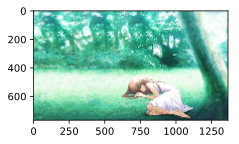

In [3]:
vis = Visualized()

vis.set_figsize()
img = plt.imread('D:/images/cartoon/g.jpg')
plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B5458544A8>,
      dtype=object)

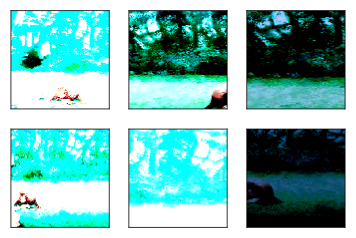

In [4]:
aug = Augment()
aug.show_images(img, aug.train)

In [5]:
imgs = aug.apply(img, aug.test)
imgs[0].shape

(3, 224, 224)

In [6]:
class XTrain(Augment):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def _get_batch(self, batch, ctx, aug):
        '''
        辅助函数::将小批量数据样本batch划分并复制到ctx变量所包含的各个 GPU 上。
        '''
        features, labels = batch
        features = nd.stack(*[self.apply(X, aug) for X in features])
        if labels.dtype != features.dtype:
            labels = labels.astype(features.dtype)
        # 当 ctx 包含多个 GPU 时，划分小批量数据样本并复制到各个 GPU 上。
        return (gutils.split_and_load(features, ctx),
                gutils.split_and_load(labels, ctx), features.shape[0])

    def evaluate_accuracy(self, data_iter, net, ctx=[mx.cpu()]):
        if isinstance(ctx, mx.Context):
            ctx = [ctx]
        acc = 0
        n = 0
        for batch in data_iter:
            features, labels, _ = self._get_batch(batch, ctx, self.test)
            for X, y in zip(features, labels):
                y = y.astype('float32')
                acc += (net(X).argmax(axis=1) ==
                        y).sum().copyto(mx.cpu()).asscalar()
                n += y.size
        return acc / n

    def train(self, train_iter, test_iter, net, loss, trainer, ctx,
              num_epochs):
        print('training on', ctx)
        if isinstance(ctx, mx.Context):
            ctx = [ctx]
        for epoch in range(num_epochs):
            train_l_sum, train_acc_sum, n, m = 0.0, 0.0, 0.0, 0.0
            start = time()
            for i, batch in enumerate(train_iter):
                Xs, ys, batch_size = self._get_batch(batch, ctx, self.train)
                ls = []
                with autograd.record():
                    y_hats = [net(X) for X in Xs]
                    ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
                for l in ls:
                    l.backward()
                train_acc_sum += sum(
                    [(y_hat.argmax(axis=1) == y).sum().asscalar()
                     for y_hat, y in zip(y_hats, ys)])
                train_l_sum += sum([l.sum().asscalar() for l in ls])
                trainer.step(batch_size)
                n += batch_size
                m += sum([y.size for y in ys])
            test_acc = self.evaluate_accuracy(test_iter, net, ctx)
            print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
                  'time %.1f sec' %
                  (epoch + 1, train_l_sum / n, train_acc_sum / m, test_acc,
                   time() - start))

In [7]:
train_op = XTrain()

In [8]:
import gluonbook as gb
lr=0.001
batch_size, ctx, net = 256, train_op.try_all_gpus(), gb.resnet18(10)
net.initialize(ctx=ctx, init=init.Xavier())
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gloss.SoftmaxCrossEntropyLoss()

In [9]:
import sys
sys.path.append('E:/zlab')
from client import cifar

In [10]:
trainset, valset = cifar.trainset, cifar.valset

In [11]:
train_op.train(trainset, valset, net, loss, trainer, ctx, num_epochs=10)

training on [gpu(0)]


TypeError: train() missing 6 required positional arguments: 'test_iter', 'net', 'loss', 'trainer', 'ctx', and 'num_epochs'